In [ ]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=49446c120e498bdb25e0807d2937eb94dd518f0e07ac2d43c3ec0588dd43d4e5
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
!nvidia-smi

Thu Jul 30 13:43:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)
time: 3.05 s


## Mount google drive


In [ ]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 17.6 s


In [ ]:
%ls "/content/drive/My Drive/dataset_s2"

flying_birds.zip        small_quandcopters.zip
large_quandCopters.zip  winged_drones.zip
time: 4.4 s


In [ ]:
!pwd

/content
time: 7.47 s


In [ ]:
from zipfile import ZipFile

def extract_images(zipfilename, targetfolder):
  
  zipObj = ZipFile(zipfilename, 'r')
  #print("zipObj " +zipObj)
  zipObj.extractall(targetfolder)
  zipObj.close()

time: 1.95 ms


In [ ]:
%mkdir flying_birds
%mkdir small_quandcopters
%mkdir large_quandCopters
%mkdir winged_drones

time: 9.18 s


In [ ]:
extract_images('/content/drive/My Drive/dataset_s2/flying_birds.zip','/content/flying_birds' )


time: 2min 14s


In [ ]:
extract_images('/content/drive/My Drive/dataset_s2/small_quandcopters.zip','/content/small_quandcopters' )


time: 9.77 s


In [ ]:
extract_images('/content/drive/My Drive/dataset_s2/large_quandCopters.zip','/content/large_quandCopters' )


time: 23.7 s


In [ ]:
extract_images('/content/drive/My Drive/dataset_s2/winged_drones.zip','/content/winged_drones' )


time: 40.2 s


In [ ]:
%ls /content/flying_birds/ | wc -l

7816
time: 3.76 s


In [ ]:
%ls /content/small_quandcopters/ | wc -l

3294
time: 3.55 s


In [ ]:
%ls /content/large_quandCopters/ | wc -l

3948
time: 3.35 s


In [ ]:
%ls /content/winged_drones/ | wc -l

4069
time: 3.68 s


In [ ]:
# USAGE
# python detect_and_remove.py --dataset dataset
# python detect_and_remove.py --dataset dataset --remove 1

# import the necessary packages
from imutils import paths
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow

def dhash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
	# compute the (relative) horizontal gradient between adjacent
	# column pixels
    diff = resized[:, 1:] > resized[:, :-1]

	# convert the difference image to a hash and return it
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
imagePaths = os.listdir('/content/large_quandCopters')
print(imagePaths)
hashes = {}

# loop over our image paths
for imagePath in imagePaths:
	# load the input image and compute the hash
    try:
        imagePath = '/content/large_quandCopters/'+imagePath

        image = cv2.imread(imagePath)
        h = dhash(image)
        #print(imagePath)
        # grab all image paths with that hash, add the current image
        # path to it, and store the list back in the hashes dictionary
        p = hashes.get(h, [])
        p.append(imagePath)
        hashes[h] = p
    except:
        print(imagePath)
        continue

# loop over the image hashes
for (h, hashedPaths) in hashes.items():
	# check to see if there is more than one image with the same hash
	if len(hashedPaths) > 1:
		# check to see if this is a dry run
		if 1 <= 0:
			# initialize a montage to store all images with the same
			# hash
			montage = None

			# loop over all image paths with the same hash
			for p in hashedPaths:
				# load the input image and resize it to a fixed width
				# and height
				image = cv2.imread(p)
				image = cv2.resize(image, (150, 150))

				# if our montage is None, initialize it
				if montage is None:
					montage = image

				# otherwise, horizontally stack the images
				else:
					montage = np.hstack([montage, image])

			# show the montage for the hash
			print("[INFO] hash: {}".format(h))
			# cv2_imshow("Montage", montage)
			# cv2.waitKey(0)

		# otherwise, we'll be removing the duplicate images
		else:
			# loop over all image paths with the same hash *except*
			# for the first image in the list (since we want to keep
			# one, and only one, of the duplicate images)
			for p in hashedPaths[1:]:
				os.remove(p)

[INFO] computing image hashes...
['images548.jpg', 'image144.jpg', 'OIPIE4ur6t1QjKAS-pbUdd7owHaEn.jpg', 'Capture41.jpg', '7121sE-6oDL._AC_SL1500_.jpg', 'Capture98.jpg', 'Capture43.jpg', 'how-to-register-a-drone.jpg', 'onyxstar_hydra-12_drone_uav_uas_multispectral_hyperspectral_imagerie_aerien_spectrographie.jpg', 'Skyf_drone.jpg', '103055283-706c6566a3be0bf4bf3a3d7c7876e0a0ea959eba.600x400.jpg', 'e77a1fda71dabc93e012f9463755e9f8-5228ede444dc3.jpg', 'file-20180202-162066-1cj3sym copy.jpg', 'drones_2.jpg', 'i (16)-1.jpeg', 'OIPRpkAmuq0l5SZ-SKqPkSaawHaEA.jpg', '200201102714-china-talking-drone-super-169.jpg', 'Qud-x9-heavy-lift.jpg', 'ii35.jpg', 'FK0WH1VHUQIGVFG.LARGE.jpg', '0_Chinese-Inventor-Builds-Flying-Scooter-Dongguan-China-12-Aug-2018.jpg', 'ii24.jpg', 'D3WtspwW4AAvKzj.jpg', 'lq13.jpg', 'images491.jpg', 'images463.jpg', '43ba18441cfd178dfc2bd5f5e542e58b.jpg', '1.EHANG_184_AAV(1).jpg', 'VWOLALNGRKJF5VU7FY2MRUFJIE.jpg', 'd76de52d9074481ba96f3d0471dbd1e7.0e591.jpg', '140911-drones-edi

In [ ]:
%mv '/content/large_quandCopters/AR_Drone_Quadrocopter_Flying500pics.jpg' .

time: 3.1 s


In [ ]:
%ls /content/flying_birds/ | wc -l

7813
time: 2.47 s


In [ ]:
%ls /content/dataset/flying_bird/ | wc -l

7813
time: 2.72 s


In [ ]:
%ls /content/dataset/small_drone/ | wc -l

3294
time: 3.43 s


In [ ]:
%ls /content/dataset/large_drone/ | wc -l

3948
time: 2.92 s


In [ ]:
%ls /content/dataset/winged_drone/ | wc -l

4069
time: 3.4 s


In [ ]:
fnum = [4069,3294,3948,7813]
flist = ['winged_drone', 'small_drone', 'large_drone', 'flying_bird' ]
for i in range(4):
  for j in range(0,fnum[i]):
    # b = f"{flist[i]}/{flist[i]}_{j}.jpg {flist[i]}\n"    
    # g = open('/content/drive/My Drive/e4p2/labels.txt','a')
    # g.write(b)
    
    c = f"{flist[i]}/{flist[i]}_{j}.jpg {i}\n"
    h = open('/content/drive/My Drive/e4p2/labels_num.txt','a')
    h.write(c)

# b = f"{flist[i]}/{flist[i]}_{j+1}.jpg {flist[i]}"
# g = open('/content/drive/My Drive/e4p2/labels.txt','a')
# g.write(b)

c = f"{flist[i]}/{flist[i]}_{j}.jpg {i}\n"
h = open('/content/drive/My Drive/e4p2/labels_num.txt','a')
h.write(c)

35

time: 49.8 s


In [ ]:
%mkdir dataset
%mkdir dataset/winged_drone
%mkdir dataset/small_drone
%mkdir dataset/large_drone
%mkdir dataset/flying_bird

time: 12.2 s


In [ ]:
import os 

# Function to rename multiple files 
def rename_files(): 
	for count, filename in enumerate(os.listdir("/content/large_quandCopters")): 
		dst ="large_drone_" + str(count) + ".jpg"
		src ='/content/large_quandCopters/'+ filename 
		dst ='/content/dataset/large_drone/'+ dst 
		#print(dst)
		# rename() function will 
		# rename all the files 
		os.rename(src, dst) 

rename_files()

time: 86.3 ms


In [ ]:
from PIL import Image
import numpy as np


time: 677 µs


In [ ]:
lfile = open('/content/drive/My Drive/e4p2/labels.txt','r').readlines()
print(lfile[0].split(',')[0])

winged_drone/winged_drone_0.jpg winged_drone

time: 6.69 ms


In [ ]:
lfile = open('/content/drive/My Drive/e4p2/labels_num.txt','r').readlines()
print(lfile[0].split(',')[0])

winged_drone/winged_drone_0.jpg 0

time: 7.69 ms


In [ ]:
%ls -la /content/dataset/winged_drone/ | head

total 297088
drwxr-xr-x 2 root root   188416 Jul 30 16:43 ./
drwxr-xr-x 6 root root     4096 Jul 30 16:42 ../
-rw-r--r-- 1 root root     4988 Jul 30 13:46 winged_drone_0.jpg
-rw-r--r-- 1 root root   383607 Jul 30 13:47 winged_drone_1000.jpg
-rw-r--r-- 1 root root    21039 Jul 30 13:47 winged_drone_1001.jpg
-rw-r--r-- 1 root root     5910 Jul 30 13:47 winged_drone_1002.jpg
-rw-r--r-- 1 root root     3889 Jul 30 13:47 winged_drone_1003.jpg
-rw-r--r-- 1 root root    11823 Jul 30 13:47 winged_drone_1004.jpg
-rw-r--r-- 1 root root     5391 Jul 30 13:47 winged_drone_1005.jpg
time: 3.53 s


In [ ]:
os.mkdir('/content/Dataset')
os.mkdir('/content/Dataset/winged_drone')
os.mkdir('/content/Dataset/small_drone')
os.mkdir('/content/Dataset/large_drone')
os.mkdir('/content/Dataset/flying_bird')

time: 2.75 ms


In [ ]:
lfile = open('/content/drive/My Drive/e4p2/labels.txt','r').readlines()
i=1

for line in lfile:
    try:
        img_path =line.split(' ')
        img = Image.open(f'/content/dataset/{img_path[0]}').convert('RGB')
        h,w = img.size[0],img.size[1]
        max_len = max(h,w)
        
        if h == w:
            img.save(f'/content/Dataset/{img_path[0]}')
            
        elif h>w:
            diff = int(abs(h-w)/2)
            black = np.zeros((max_len,max_len))
            black_img = Image.fromarray(black,mode='RGB')
            
            black_img.paste(img,(0,diff))
            black_img.save(f'/content/Dataset/{img_path[0]}')
            
        elif w>h:
            diff = int(abs(h-w)/2)
            black = np.zeros((max_len,max_len))
            black_img = Image.fromarray(black,mode='RGB')
            black_img.paste(img,(diff,0))
            black_img.save(f'/content/Dataset/{img_path[0]}')
        
        print(img_path[0],end=' ')
        
        if i%4 ==0:
            print('\n')
            i+=1
    except:
        print("not recognized")
        continue

winged_drone/winged_drone_0.jpg winged_drone/winged_drone_1.jpg winged_drone/winged_drone_2.jpg winged_drone/winged_drone_3.jpg winged_drone/winged_drone_4.jpg winged_drone/winged_drone_5.jpg winged_drone/winged_drone_6.jpg winged_drone/winged_drone_7.jpg winged_drone/winged_drone_8.jpg winged_drone/winged_drone_9.jpg 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


winged_drone/winged_drone_10.jpg winged_drone/winged_drone_11.jpg winged_drone/winged_drone_12.jpg winged_drone/winged_drone_13.jpg winged_drone/winged_drone_14.jpg winged_drone/winged_drone_15.jpg winged_drone/winged_drone_16.jpg winged_drone/winged_drone_17.jpg winged_drone/winged_drone_18.jpg winged_drone/winged_drone_19.jpg winged_drone/winged_drone_20.jpg winged_drone/winged_drone_21.jpg winged_drone/winged_drone_22.jpg winged_drone/winged_drone_23.jpg winged_drone/winged_drone_24.jpg winged_drone/winged_drone_25.jpg winged_drone/winged_drone_26.jpg winged_drone/winged_drone_27.jpg winged_drone/winged_drone_28.jpg winged_drone/winged_drone_29.jpg winged_drone/winged_drone_30.jpg winged_drone/winged_drone_31.jpg winged_drone/winged_drone_32.jpg winged_drone/winged_drone_33.jpg winged_drone/winged_drone_34.jpg winged_drone/winged_drone_35.jpg winged_drone/winged_drone_36.jpg winged_drone/winged_drone_37.jpg winged_drone/winged_drone_38.jpg winged_drone/winged_drone_39.jpg winged_dro

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


large_drone/large_drone_3831.jpg large_drone/large_drone_3832.jpg large_drone/large_drone_3833.jpg large_drone/large_drone_3834.jpg large_drone/large_drone_3835.jpg large_drone/large_drone_3836.jpg large_drone/large_drone_3837.jpg large_drone/large_drone_3838.jpg large_drone/large_drone_3839.jpg large_drone/large_drone_3840.jpg large_drone/large_drone_3841.jpg large_drone/large_drone_3842.jpg large_drone/large_drone_3843.jpg large_drone/large_drone_3844.jpg large_drone/large_drone_3845.jpg large_drone/large_drone_3846.jpg large_drone/large_drone_3847.jpg large_drone/large_drone_3848.jpg large_drone/large_drone_3849.jpg large_drone/large_drone_3850.jpg large_drone/large_drone_3851.jpg large_drone/large_drone_3852.jpg large_drone/large_drone_3853.jpg large_drone/large_drone_3854.jpg large_drone/large_drone_3855.jpg large_drone/large_drone_3856.jpg large_drone/large_drone_3857.jpg large_drone/large_drone_3858.jpg large_drone/large_drone_3859.jpg large_drone/large_drone_3860.jpg large_dron

In [ ]:
%ls '/content/Dataset/flying_bird' | wc -l
%ls '/content/Dataset/large_drone' | wc -l
%ls '/content/Dataset/small_drone' | wc -l
%ls '/content/Dataset/winged_drone'| wc -l

7813
3948
3294
4069
time: 10.7 s


In [ ]:
#Export Zip file
from zipfile import ZipFile 
import zipfile
  
def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         
  
def main(): 
    # path to folder which needs to be zipped 
    directory = 'Dataset'
  
    # calling function to get all file paths in the directory 
    file_paths = get_all_file_paths(directory) 
  
    # printing the list of all files to be zipped 
    # print('Following files will be zipped:') 
    # for file_name in file_paths: 
    #     print(file_name) 
  
    # writing files to a zipfile 
    with ZipFile('/content/drive/My Drive/e4p2/dataset_final.zip','a', compression = zipfile.ZIP_DEFLATED) as zip: 
        # writing each file one by one 
        for file in file_paths: 
            zip.write(file) 
  
    print('All files zipped successfully!')         
  
  

main()

All files zipped successfully!
time: 59.5 s


In [ ]:
%mkdir new

time: 3.13 s


In [ ]:
extract_images('/content/drive/My Drive/e4p2/dataset_padded.zip','/content/new')


time: 26 s


In [ ]:
%ls '/content/new/Dataset/flying_bird' | wc -l
%ls '/content/new/Dataset/large_drone' | wc -l
%ls '/content/new/Dataset/small_drone' | wc -l
%ls '/content/new/Dataset/winged_drone'| wc -l

8336
4155
3620
5591
time: 11.4 s


In [ ]:

import os.path
from os import path 
import os 

source = '/content/flying_birds'
for i in os.listdir(source):
    not_jpg = i.split('.')[-1]
    if not_jpg != "jpg" and not_jpg != "jpeg" and not_jpg != "webp":
        new_jpg = i.split('.')[-2] +".jpg"
        os.rename(source+"/"+i, source+"/"+new_jpg)
    elif not_jpg == 'webp' or not_jpg == 'gif':
        os.remove(source+"/"+i)

time: 16.6 ms


In [ ]:
from IPython.display import Image
Image('/content/dataset/winged_drone/winged_drone_0.jpg') 

time: 4.88 ms


In [ ]:
import shutil
shutil.make_archive('flying_birds', 'zip', '/content/flying_birds')

'/content/flying_birds.zip'

time: 2min 11s


In [ ]:
%mv /content/flying_birds.zip /content/drive/My\ Drive/

time: 52.9 s


In [ ]:
count = 0
sizes_new = []
source = '/content/flying_birds'
for i in os.listdir(source):
    print(i)
    size = os.path.getsize(source+"/"+i)    
    sizes_new.append(size)

print(sizes_new[-10:])
print(count)

SyntaxError: ignored

In [ ]:
count_1 = 0

source = '/content/flying_birds'

for size in sizes_new:
    if size > 15000:
        count_1 += 1
print(count_1)

3841
time: 9.29 ms


flying_birds:8336
large_copters:4155
small_copters:3620
drone:5591


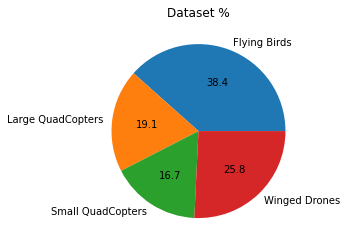

time: 217 ms


In [ ]:
import matplotlib.pyplot as plt

classes =  [ 'Flying Birds', 'Large QuadCopters', 'Small QuadCopters','Winged Drones' ]

source = "/content/Dataset"
flying_birds = len(os.listdir(source + '/flying_bird'))
large_copters = len(os.listdir(source + '/large_drone'))
small_copters = len(os.listdir(source + '/small_drone'))
drone = len(os.listdir(source + '/winged_drone'))

print("flying_birds:"+str(flying_birds ))
print("large_copters:"+str(large_copters))
print("small_copters:"+str(small_copters))
print("drone:"+str(drone))

#pie plot 
plt.pie([flying_birds, large_copters, small_copters, drone], labels=classes, autopct='%0.1f') 

#label the plot 
plt.title('Dataset %') 
# plt.savefig('C:\\Users\\Dell\\Desktop\\AV Plotting images\\matplotlib_plotting_8.png',dpi=300,bbox_inches='tight') 
plt.show()

In [ ]:
classes =  [ 'Flying Birds', 'Large QuadCopters', 'Small QuadCopters','Winged Drones' ]
dataFolder = '/content/drive/My Drive/eva-4/Phase-2/Session-2/ds'
zipFilePath = '/content/drive/My Drive/s2_Dataset'

time: 1.28 ms


## Read Dataset

In [ ]:
import torchvision.transforms as transforms
transform = {
        'train': transforms.Compose([
            transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ]),
        'test': transforms.Compose([
            transforms.Resize([224,224]),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])
    }

time: 465 ms


## DataLoader

In [ ]:
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
def load_data(imageFolder):
  dataset = torchvision.datasets.ImageFolder(imageFolder,transform=transform['train'])
  print(dataset.classes)

  # print(dataset.targets)
  def get_subset(indices, start, end):
      return indices[start : start + end]

  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  TRAIN_PCT, TEST_PCT = 0.7, 0.3  
  train_count = int(len(dataset) * TRAIN_PCT)
  test_count = int(len(dataset) * TEST_PCT)

  indices = torch.randperm(len(dataset))


  train_idx = get_subset(indices, 0, train_count)
  print(len(train_idx))
  test_idx = get_subset(indices, train_count, len(dataset))
  trainloader=torch.utils.data.DataLoader(dataset,batch_size=32,num_workers=4, pin_memory=True,sampler=SubsetRandomSampler(train_idx))
  testloader=  torch.utils.data.DataLoader(dataset,batch_size=32,num_workers=4, pin_memory=True,sampler=SubsetRandomSampler(test_idx))
  return trainloader, testloader, dataset

time: 17 ms


In [ ]:
train_loader, val_loader, dataset=load_data('/content/new/Dataset')

['flying_bird', 'large_drone', 'small_drone', 'winged_drone']
CUDA Available? True
15191
time: 133 ms


## Display Images

In [ ]:
import torchvision
from matplotlib import pyplot as plt

def show(imgs,lbls=None, figsize=(100,100), *args, **kwargs):
    grid_tensor = torchvision.utils.make_grid(imgs[:8], *args, **kwargs)
    grid_image = grid_tensor.permute(1,2,0)
    plt.figtext(100,100,'Images')
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if lbls is not None:
        print(' '.join('%22s' % [lbls[j]] for j in range(10)))
    plt.close()

time: 9.21 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

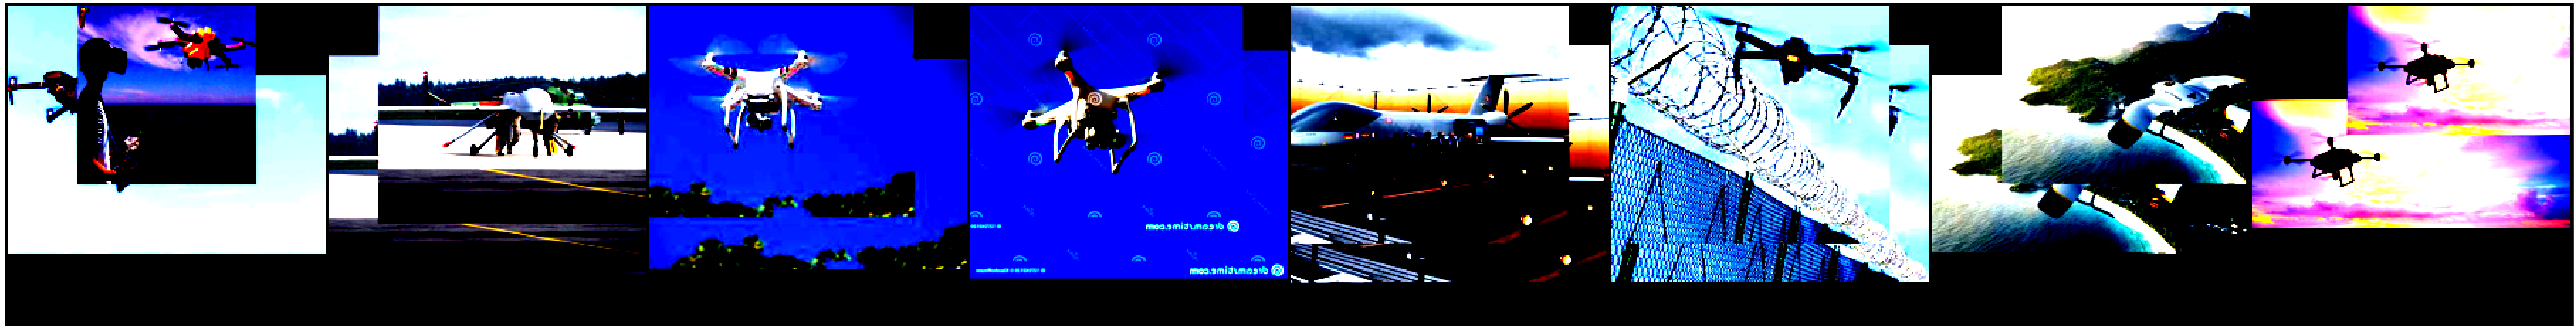

           [tensor(1)]            [tensor(3)]            [tensor(2)]            [tensor(2)]            [tensor(3)]            [tensor(2)]            [tensor(3)]            [tensor(1)]            [tensor(0)]            [tensor(3)]
time: 13.5 s


In [ ]:
import numpy as np
image, label = next(iter(train_loader))
show(image,label)

## Load model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=False)
model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 1.51 s


#### Freeze and modify final layer

In [ ]:
for param in model.parameters():
    param.requires_grad = False    

n_inputs = model.classifier[1].in_features

model.classifier = torch.nn.Sequential(torch.nn.Linear(n_inputs, 512),
                            # torch.nn.ReLU6(),
                            # torch.nn.Dropout(0.2),
                            torch.nn.Linear(512, 4),
                            torch.nn.LogSoftmax(dim=1))

time: 14.2 ms


In [ ]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 15.4 ms


### Define loss function and optimizer

In [ ]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.01
momentum = 0.9
step_size = 2
gamma = 0.96

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=momentum,
    nesterov=True) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=1,
    verbose=False, 
    threshold=0.0001,
    threshold_mode='abs',
    cooldown=0, 
    min_lr=1e-8,
    eps=1e-08
)


time: 11.8 ms


In [ ]:
class EarlyStoppingOnAcc:
    def __init__(self, patience=7, mode="max", delta=0.0001, model_path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.model_path = model_path
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            torch.save(model.state_dict(), model_path)
            traced_model = torch.jit.trace(model.float(), torch.randn(1,3,224,224).to(device))
            torch.jit.save(traced_model, 'modelnet_v2_44_77.pt')
            # traced_model.save('modelnet_v2_44_77.pt')
            torch.save(model, 'model.pt')
        self.val_score = epoch_score

time: 34.9 ms


## Train Model

In [ ]:
from torch.autograd import Variable

def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    early_stopping = EarlyStoppingOnAcc(patience=patience)
    
    for epoch in range(1, n_epochs + 1):
        for param_group in optimizer.param_groups:
          lr = param_group["lr"]
          print(f'\n **** learning rate: {lr}')
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for inputs, target in train_loader:
            inputs, target = inputs.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            
            # loss = Variable(loss, requires_grad = True)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        correct = 0
        total = 0
        accuracy = 0
        for inputs, target in val_loader:
            inputs, target = inputs.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        valid_accuracy = 100 * correct / total

        epoch_len = len(str(n_epochs))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'\tvalid_loss: {valid_loss:.5f}' +
                     f'\tvalid_accuracy: {valid_accuracy:.2f}')
        
        print(print_msg)

        # Tensorboard logging
        '''tb.add_scalar('Loss - Train loss',
                            train_loss / len(train_loader),
                            epoch * len(train_loader))
            
        tb.add_scalar('Loss - Val',
                        valid_loss/len(val_loader),
                        epoch * len(val_loader))
        
        tb.add_scalar('Accuracy - Val',
                            valid_accuracy/len(val_loader),
                            epoch * len(val_loader))'''
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        valid_accuracy = round(valid_accuracy, 2)
        scheduler.step(valid_accuracy)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        model_path = 'checkpoint.pt' # f'jantahackathon_v13_{valid_accuracy}.pth'
        early_stopping(valid_accuracy, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            if early_stopping.best_score is not None:
              print(f'Best score: {early_stopping.best_score}')
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_path))

    return  model, avg_train_losses, avg_valid_losses

time: 82.7 ms


In [ ]:
batch_size = 512
n_epochs = 30

# train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)


 **** learning rate: 0.01


KeyboardInterrupt: ignored

time: 5min 13s


## Visualizing the loss

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Load the saved model

In [ ]:
!ls

 checkpoint.pt	'Large QuadCopters'   modelnet_v2_44_77.pt  'Small QuadCopters'
'Flying Birds'	 loss_plot.png	      model.pt		    'Winged Drones'
time: 3.01 s


In [ ]:
loadedModel = torch.jit.load('modelnet_v2_44_77.pt')
print(loadedModel)

RecursiveScriptModule(
  original_name=MobileNetV2
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ConvBNReLU
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU6)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ConvBNReLU
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU6)
        )
        (1): RecursiveScriptModule(original_name=Conv2d)
        (2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
    )
    (2): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
     

In [ ]:
model=torch.load('./model.pt')
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 96.6 ms


In [ ]:
from torchvision import transforms
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

time: 1.43 ms


In [ ]:

from torch.autograd import Variable

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #input = image
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

time: 8.94 ms


In [ ]:
def get_random_images(num):
    '''data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)'''
    dataiter = iter(val_loader)
    images, labels = dataiter.next()
    return images, labels

time: 2.47 ms


## Validate Model

Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 2 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified 

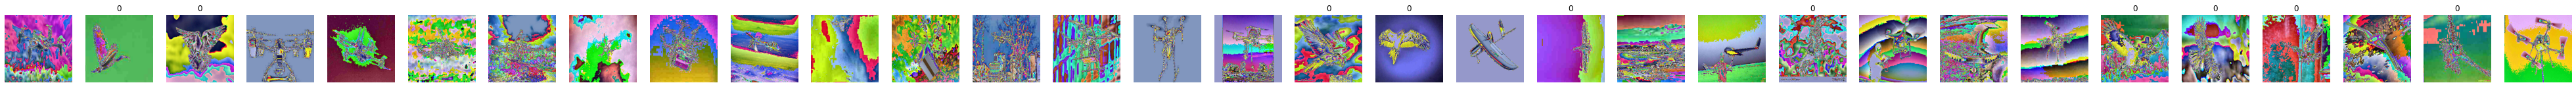

time: 6.8 s


In [ ]:

from matplotlib import pyplot as plt

to_pil = torchvision.transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(70,70))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    #print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    if res:
        sub.set_title(index)
    else:
        print('Misclassified Image :\n\tActual Label : {} and predicted : {}'.format(int(labels[ii]),index))
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Test model

In [ ]:
from matplotlib import pyplot as plt
predClass = []

#for _ in np.arange(float(len(testDs))/8.0+1): 
data = iter(val_loader)
#for v in np.arange(float(len(testDs))/8.0+1): 
from IPython.core.debugger import set_trace
res = True
row = 1
while res:
    try:
        images = data.next()
        res = False if len(images)==0 else True
    except Exception as e:
        print(str(e))
        break
    to_pil = torchvision.transforms.ToPILImage()

    print(f'Row : {row}')
    row = row + 1
    #fig=plt.figure(figsize=(30,30))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        index = predict_image(image)
        predClass.append(index)
        #sub = fig.add_subplot(1, len(images), ii+1)
        #sub.set_title(index)
        #plt.axis('off')
        #plt.imshow(image)
    #plt.show()
    #set_trace()

Row : 1


ValueError: ignored

time: 2.97 s


In [ ]:
print(len(np.array(predClass)))